In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_075_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:19 - loss: 0.0123 - STD: 2.5419e-04 - MAE: 0.0944

 4/64 [>.............................] - ETA: 1s - loss: 0.0139 - STD: 3.1786e-04 - MAE: 0.0884  

 5/64 [=>............................] - ETA: 2s - loss: 0.0131 - STD: 3.9571e-04 - MAE: 0.0869

 6/64 [=>............................] - ETA: 2s - loss: 0.0131 - STD: 4.8594e-04 - MAE: 0.0888

 7/64 [==>...........................] - ETA: 2s - loss: 0.0130 - STD: 5.6897e-04 - MAE: 0.0894

 8/64 [==>...........................] - ETA: 2s - loss: 0.0126 - STD: 6.3717e-04 - MAE: 0.0884

 9/64 [===>..........................] - ETA: 2s - loss: 0.0123 - STD: 6.9023e-04 - MAE: 0.0870

10/64 [===>..........................] - ETA: 2s - loss: 0.0122 - STD: 7.3345e-04 - MAE: 0.0860

11/64 [====>.........................] - ETA: 2s - loss: 0.0121 - STD: 7.7455e-04 - MAE: 0.0852

12/64 [====>.........................] - ETA: 2s - loss: 0.0120 - STD: 8.1828e-04 - MAE: 0.0845

13/64 [=====>........................] - ETA: 2s - loss: 0.0119 - STD: 8.6854e-04 - MAE: 0.0838

14/64 [=====>........................] - ETA: 2s - loss: 0.0117 - STD: 9.2845e-04 - MAE: 0.0832

15/64 [======>.......................] - ETA: 2s - loss: 0.0116 - STD: 9.9475e-04 - MAE: 0.0831

16/64 [======>.......................] - ETA: 2s - loss: 0.0115 - STD: 0.0011 - MAE: 0.0831    

17/64 [======>.......................] - ETA: 2s - loss: 0.0115 - STD: 0.0011 - MAE: 0.0832

18/64 [=======>......................] - ETA: 2s - loss: 0.0114 - STD: 0.0012 - MAE: 0.0832

19/64 [=======>......................] - ETA: 2s - loss: 0.0113 - STD: 0.0013 - MAE: 0.0830

20/64 [========>.....................] - ETA: 2s - loss: 0.0113 - STD: 0.0013 - MAE: 0.0827

21/64 [========>.....................] - ETA: 2s - loss: 0.0112 - STD: 0.0014 - MAE: 0.0824

22/64 [=========>....................] - ETA: 2s - loss: 0.0112 - STD: 0.0014 - MAE: 0.0820

23/64 [=========>....................] - ETA: 2s - loss: 0.0111 - STD: 0.0015 - MAE: 0.0817

24/64 [==========>...................] - ETA: 2s - loss: 0.0111 - STD: 0.0016 - MAE: 0.0815

25/64 [==========>...................] - ETA: 2s - loss: 0.0110 - STD: 0.0016 - MAE: 0.0812

26/64 [===========>..................] - ETA: 2s - loss: 0.0109 - STD: 0.0017 - MAE: 0.0811

27/64 [===========>..................] - ETA: 2s - loss: 0.0109 - STD: 0.0018 - MAE: 0.0810

28/64 [============>.................] - ETA: 2s - loss: 0.0109 - STD: 0.0019 - MAE: 0.0809

29/64 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 0.0020 - MAE: 0.0809

30/64 [=============>................] - ETA: 2s - loss: 0.0108 - STD: 0.0021 - MAE: 0.0808

31/64 [=============>................] - ETA: 2s - loss: 0.0107 - STD: 0.0022 - MAE: 0.0806

32/64 [==============>...............] - ETA: 1s - loss: 0.0107 - STD: 0.0023 - MAE: 0.0804

33/64 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 0.0024 - MAE: 0.0803

34/64 [==============>...............] - ETA: 1s - loss: 0.0106 - STD: 0.0025 - MAE: 0.0801

35/64 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 0.0026 - MAE: 0.0800

36/64 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 0.0027 - MAE: 0.0799

37/64 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 0.0029 - MAE: 0.0798

38/64 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 0.0030 - MAE: 0.0797

42/64 [==================>...........] - ETA: 1s - loss: 0.0104 - STD: 0.0038 - MAE: 0.0795

43/64 [===================>..........] - ETA: 1s - loss: 0.0104 - STD: 0.0040 - MAE: 0.0794

44/64 [===================>..........] - ETA: 1s - loss: 0.0103 - STD: 0.0043 - MAE: 0.0792

45/64 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.0045 - MAE: 0.0791

46/64 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.0048 - MAE: 0.0790

47/64 [=====================>........] - ETA: 1s - loss: 0.0102 - STD: 0.0051 - MAE: 0.0789

48/64 [=====================>........] - ETA: 1s - loss: 0.0102 - STD: 0.0054 - MAE: 0.0788

49/64 [=====================>........] - ETA: 1s - loss: 0.0102 - STD: 0.0058 - MAE: 0.0787

50/64 [======================>.......] - ETA: 0s - loss: 0.0101 - STD: 0.0062 - MAE: 0.0786

51/64 [======================>.......] - ETA: 0s - loss: 0.0101 - STD: 0.0066 - MAE: 0.0784

52/64 [=======================>......] - ETA: 0s - loss: 0.0101 - STD: 0.0070 - MAE: 0.0783

53/64 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 0.0074 - MAE: 0.0782

54/64 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 0.0079 - MAE: 0.0781

55/64 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 0.0083 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.0088 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.0093 - MAE: 0.0777

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 0.0098 - MAE: 0.0776

59/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0103 - MAE: 0.0775

60/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0108 - MAE: 0.0773

61/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0113 - MAE: 0.0772

62/64 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0118 - MAE: 0.0771

63/64 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0123 - MAE: 0.0770

64/64 [==============================] - ETA: 0s - loss: 0.0097 - STD: 0.0127 - MAE: 0.0769

64/64 [==============================] - 6s 79ms/step - loss: 0.0097 - STD: 0.0127 - MAE: 0.0769 - val_loss: 0.0076 - val_STD: 0.0293 - val_MAE: 0.0684


Epoch 2/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0074 - STD: 0.0414 - MAE: 0.0673

 2/64 [..............................] - ETA: 5s - loss: 0.0079 - STD: 0.0408 - MAE: 0.0681

 3/64 [>.............................] - ETA: 4s - loss: 0.0080 - STD: 0.0403 - MAE: 0.0685

 4/64 [>.............................] - ETA: 4s - loss: 0.0079 - STD: 0.0400 - MAE: 0.0686

 5/64 [=>............................] - ETA: 4s - loss: 0.0079 - STD: 0.0399 - MAE: 0.0689

 6/64 [=>............................] - ETA: 4s - loss: 0.0080 - STD: 0.0397 - MAE: 0.0693

 7/64 [==>...........................] - ETA: 4s - loss: 0.0079 - STD: 0.0396 - MAE: 0.0693

 8/64 [==>...........................] - ETA: 3s - loss: 0.0079 - STD: 0.0393 - MAE: 0.0692

 9/64 [===>..........................] - ETA: 3s - loss: 0.0079 - STD: 0.0392 - MAE: 0.0691

10/64 [===>..........................] - ETA: 3s - loss: 0.0079 - STD: 0.0391 - MAE: 0.0691

11/64 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.0390 - MAE: 0.0690

12/64 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.0391 - MAE: 0.0690

13/64 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.0392 - MAE: 0.0690

14/64 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.0392 - MAE: 0.0690

15/64 [======>.......................] - ETA: 3s - loss: 0.0079 - STD: 0.0394 - MAE: 0.0689

16/64 [======>.......................] - ETA: 3s - loss: 0.0079 - STD: 0.0395 - MAE: 0.0688

17/64 [======>.......................] - ETA: 3s - loss: 0.0079 - STD: 0.0397 - MAE: 0.0688

18/64 [=======>......................] - ETA: 3s - loss: 0.0078 - STD: 0.0399 - MAE: 0.0687

19/64 [=======>......................] - ETA: 3s - loss: 0.0078 - STD: 0.0401 - MAE: 0.0687

20/64 [========>.....................] - ETA: 2s - loss: 0.0078 - STD: 0.0404 - MAE: 0.0687

21/64 [========>.....................] - ETA: 2s - loss: 0.0078 - STD: 0.0406 - MAE: 0.0686

22/64 [=========>....................] - ETA: 2s - loss: 0.0078 - STD: 0.0408 - MAE: 0.0685

23/64 [=========>....................] - ETA: 2s - loss: 0.0078 - STD: 0.0409 - MAE: 0.0685

24/64 [==========>...................] - ETA: 2s - loss: 0.0078 - STD: 0.0411 - MAE: 0.0684

25/64 [==========>...................] - ETA: 2s - loss: 0.0078 - STD: 0.0413 - MAE: 0.0683

26/64 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0414 - MAE: 0.0682

27/64 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0415 - MAE: 0.0681

28/64 [============>.................] - ETA: 2s - loss: 0.0077 - STD: 0.0416 - MAE: 0.0681

29/64 [============>.................] - ETA: 2s - loss: 0.0077 - STD: 0.0417 - MAE: 0.0680

30/64 [=============>................] - ETA: 2s - loss: 0.0077 - STD: 0.0417 - MAE: 0.0679

31/64 [=============>................] - ETA: 2s - loss: 0.0077 - STD: 0.0418 - MAE: 0.0679

32/64 [==============>...............] - ETA: 2s - loss: 0.0077 - STD: 0.0419 - MAE: 0.0678

33/64 [==============>...............] - ETA: 2s - loss: 0.0077 - STD: 0.0420 - MAE: 0.0677

34/64 [==============>...............] - ETA: 2s - loss: 0.0076 - STD: 0.0421 - MAE: 0.0676

35/64 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0422 - MAE: 0.0675

36/64 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0423 - MAE: 0.0674

37/64 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.0425 - MAE: 0.0673

38/64 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.0426 - MAE: 0.0672

39/64 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0428 - MAE: 0.0671

40/64 [=================>............] - ETA: 1s - loss: 0.0075 - STD: 0.0429 - MAE: 0.0670

41/64 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0430 - MAE: 0.0669

42/64 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0433 - MAE: 0.0668

43/64 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.0434 - MAE: 0.0667

44/64 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.0436 - MAE: 0.0666

45/64 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0438 - MAE: 0.0665

46/64 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0440 - MAE: 0.0663

47/64 [=====================>........] - ETA: 1s - loss: 0.0074 - STD: 0.0442 - MAE: 0.0662

48/64 [=====================>........] - ETA: 1s - loss: 0.0074 - STD: 0.0444 - MAE: 0.0660

49/64 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.0447 - MAE: 0.0660

50/64 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0449 - MAE: 0.0659

51/64 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0452 - MAE: 0.0657

52/64 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0455 - MAE: 0.0656

53/64 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0457 - MAE: 0.0655

54/64 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0461 - MAE: 0.0656

55/64 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0462 - MAE: 0.0655

56/64 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0465 - MAE: 0.0653

57/64 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0469 - MAE: 0.0655

58/64 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.0470 - MAE: 0.0654

59/64 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.0471 - MAE: 0.0653

60/64 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0474 - MAE: 0.0653

61/64 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0476 - MAE: 0.0652

62/64 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0477 - MAE: 0.0651

63/64 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0478 - MAE: 0.0650

64/64 [==============================] - ETA: 0s - loss: 0.0072 - STD: 0.0480 - MAE: 0.0650

64/64 [==============================] - 4s 71ms/step - loss: 0.0072 - STD: 0.0480 - MAE: 0.0650 - val_loss: 0.0059 - val_STD: 0.0494 - val_MAE: 0.0618


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0065 - STD: 0.0610 - MAE: 0.0638

 2/64 [..............................] - ETA: 4s - loss: 0.0065 - STD: 0.0568 - MAE: 0.0612

 3/64 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0546 - MAE: 0.0599

 4/64 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0551 - MAE: 0.0600

 5/64 [=>............................] - ETA: 3s - loss: 0.0064 - STD: 0.0561 - MAE: 0.0609

 6/64 [=>............................] - ETA: 3s - loss: 0.0064 - STD: 0.0562 - MAE: 0.0605

 7/64 [==>...........................] - ETA: 3s - loss: 0.0064 - STD: 0.0556 - MAE: 0.0602

 8/64 [==>...........................] - ETA: 3s - loss: 0.0064 - STD: 0.0554 - MAE: 0.0601

 9/64 [===>..........................] - ETA: 3s - loss: 0.0064 - STD: 0.0559 - MAE: 0.0603

10/64 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0562 - MAE: 0.0604

11/64 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0560 - MAE: 0.0602

12/64 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0557 - MAE: 0.0600

13/64 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.0559 - MAE: 0.0599

14/64 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.0562 - MAE: 0.0600

15/64 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.0563 - MAE: 0.0599

16/64 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0562 - MAE: 0.0597

17/64 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0562 - MAE: 0.0596

18/64 [=======>......................] - ETA: 3s - loss: 0.0062 - STD: 0.0565 - MAE: 0.0596

19/64 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0567 - MAE: 0.0596

20/64 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0567 - MAE: 0.0594

21/64 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0567 - MAE: 0.0593

22/64 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0569 - MAE: 0.0593

23/64 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0572 - MAE: 0.0593

24/64 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0573 - MAE: 0.0593

25/64 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0573 - MAE: 0.0591

26/64 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0575 - MAE: 0.0591

27/64 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0577 - MAE: 0.0591

28/64 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0578 - MAE: 0.0590

29/64 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0578 - MAE: 0.0589

30/64 [=============>................] - ETA: 2s - loss: 0.0061 - STD: 0.0580 - MAE: 0.0589

31/64 [=============>................] - ETA: 2s - loss: 0.0061 - STD: 0.0582 - MAE: 0.0588

32/64 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0583 - MAE: 0.0588

33/64 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0584 - MAE: 0.0587

34/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0585 - MAE: 0.0587

35/64 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0587 - MAE: 0.0586

36/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0588 - MAE: 0.0586

37/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0589 - MAE: 0.0586

39/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0592 - MAE: 0.0586

40/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0593 - MAE: 0.0585

41/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0585

42/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0595 - MAE: 0.0584

43/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0584

44/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0583

45/64 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0598 - MAE: 0.0583

46/64 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0599 - MAE: 0.0583

47/64 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0599 - MAE: 0.0582

48/64 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0582

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0581

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0602 - MAE: 0.0581

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0602 - MAE: 0.0580

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0603 - MAE: 0.0580

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0603 - MAE: 0.0580

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0604 - MAE: 0.0580

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0604 - MAE: 0.0579

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0605 - MAE: 0.0579

57/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0606 - MAE: 0.0578

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0606 - MAE: 0.0578

59/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0578

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0577

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0608 - MAE: 0.0577

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0577

63/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0576

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0576

64/64 [==============================] - 4s 69ms/step - loss: 0.0059 - STD: 0.0609 - MAE: 0.0576 - val_loss: 0.0051 - val_STD: 0.0568 - val_MAE: 0.0558


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0059 - STD: 0.0688 - MAE: 0.0591

 2/64 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0660 - MAE: 0.0570

 3/64 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0562

 4/64 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0565

 5/64 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0561

 6/64 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0559

 7/64 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0563

 8/64 [==>...........................] - ETA: 3s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0560

 9/64 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0561

10/64 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0560

11/64 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0558

12/64 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0559

13/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0650 - MAE: 0.0557

14/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0556

15/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0650 - MAE: 0.0557

16/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0555

17/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0555

18/64 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0555

19/64 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0555

20/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0555

21/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0554

22/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0553

23/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0555

24/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0554

25/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0553

26/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0555

27/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0555

28/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0554

29/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0556

30/64 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0557

31/64 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0645 - MAE: 0.0556

32/64 [==============>...............] - ETA: 2s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0561

33/64 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

34/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

35/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0568

36/64 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0567

37/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

38/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

39/64 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0569

40/64 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0568

41/64 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0568

42/64 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0567

43/64 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0568

44/64 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0568

45/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0568

46/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0624 - MAE: 0.0567

47/64 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0624 - MAE: 0.0567

48/64 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0624 - MAE: 0.0568

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0623 - MAE: 0.0567

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0567

51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0567

52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0568

53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0567

54/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0567

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0620 - MAE: 0.0566

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0566

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0566

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0565

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0621 - MAE: 0.0565

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0565

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0623 - MAE: 0.0564

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0564

63/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0623 - MAE: 0.0563

64/64 [==============================] - 4s 69ms/step - loss: 0.0057 - STD: 0.0624 - MAE: 0.0563 - val_loss: 0.0047 - val_STD: 0.0563 - val_MAE: 0.0523


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0536

 2/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0528

 3/64 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0531

 4/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0536

 5/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0533

 6/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0532

 7/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0534

 8/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0535

 9/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0534

10/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0533

11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0534

12/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0533

13/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0533

14/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0534

15/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0533

16/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0533

17/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0532

18/64 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0532

19/64 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0532

20/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0532

21/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0531

22/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0531

23/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0530

24/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0530

25/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0530

26/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0530

27/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0529

28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0529

29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0528

30/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0528

31/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0528

32/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0528

33/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0528

34/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0528

35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0528

36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0527

37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0527

38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0527

39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0527

40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0527

41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0526

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0526

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0526

44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0526

45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0526

46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0526

47/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0526

48/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0526

49/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0526

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0525

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0525

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0525

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0524

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0524

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0524

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0524

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0524

59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0524

60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0524

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0524

62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0524

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0524

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0524

64/64 [==============================] - 4s 70ms/step - loss: 0.0050 - STD: 0.0690 - MAE: 0.0524 - val_loss: 0.0044 - val_STD: 0.0629 - val_MAE: 0.0510


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0521

 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0515

 3/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0511

 4/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0513

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0514

 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0516

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0515

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0517

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0517

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0517

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0517

17/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516

18/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0517

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0517

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0518

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0518

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0518

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0518

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0518

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0520

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0521

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0521

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0522

32/64 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

33/64 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0524

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0524

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0525

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0525

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0524

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0524

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0524

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0524

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0524

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0524

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0523

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0523

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0523

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0523

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0522

48/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0522

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0522

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0521

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0521

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0521

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0521

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0520

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0520

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0520

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0520

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0519

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0519

64/64 [==============================] - 5s 70ms/step - loss: 0.0048 - STD: 0.0697 - MAE: 0.0519 - val_loss: 0.0046 - val_STD: 0.0592 - val_MAE: 0.0500


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0517

 2/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0729 - MAE: 0.0533

 3/64 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0698 - MAE: 0.0531

 4/64 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0535

 5/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0708 - MAE: 0.0529

 6/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0713 - MAE: 0.0528

 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0713 - MAE: 0.0525

 8/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0710 - MAE: 0.0522

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0521

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0518

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0519

13/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0518

14/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0705 - MAE: 0.0519

15/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0705 - MAE: 0.0518

16/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0517

17/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0519

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0517

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0517

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0517

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0516

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0515

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0515

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0516

33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0515

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0515

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0515

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0515

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0514

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0514

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0513

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0513

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0513

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0513

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0512

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0511

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0513

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0513

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0513

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0513

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0514

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0514

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0514

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0515

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0515

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0515

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0516

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0517

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0517

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0520

62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0523

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0525

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0529

64/64 [==============================] - 4s 70ms/step - loss: 0.0051 - STD: 0.0699 - MAE: 0.0529 - val_loss: 0.0047 - val_STD: 0.0501 - val_MAE: 0.0507


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0561 - MAE: 0.0514

 2/64 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0512 - MAE: 0.0544

 3/64 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0538 - MAE: 0.0538

 4/64 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.0580 - MAE: 0.0577

 5/64 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0570 - MAE: 0.0565

 6/64 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0552 - MAE: 0.0565

 7/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0549 - MAE: 0.0560

 8/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0563 - MAE: 0.0570

 9/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0566 - MAE: 0.0570

10/64 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0558 - MAE: 0.0566

11/64 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0553 - MAE: 0.0563

12/64 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0557 - MAE: 0.0563

13/64 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0565 - MAE: 0.0566

14/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0566 - MAE: 0.0564

15/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0563 - MAE: 0.0561

16/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0564 - MAE: 0.0558

17/64 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0570 - MAE: 0.0558

18/64 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0557

19/64 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0555

20/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0553

21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0551

22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0551

23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0549

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0547

25/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0546

26/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0545

27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0602 - MAE: 0.0544

28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0605 - MAE: 0.0542

29/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0541

30/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0612 - MAE: 0.0540

32/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0617 - MAE: 0.0538

33/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0621 - MAE: 0.0538

34/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0624 - MAE: 0.0537

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0626 - MAE: 0.0536

36/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0629 - MAE: 0.0535

37/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0534

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0534

39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0637 - MAE: 0.0533

40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0639 - MAE: 0.0532

41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0641 - MAE: 0.0531

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0644 - MAE: 0.0530

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0646 - MAE: 0.0530

44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0648 - MAE: 0.0529

45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0650 - MAE: 0.0528

46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0652 - MAE: 0.0528

47/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0527

48/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0655 - MAE: 0.0527

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0526

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0658 - MAE: 0.0526

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0660 - MAE: 0.0525

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0525

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0662 - MAE: 0.0524

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0524

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0524

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0523

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0666 - MAE: 0.0523

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0522

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0522

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0521

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0521

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0521

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0520

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0672 - MAE: 0.0520

64/64 [==============================] - 4s 70ms/step - loss: 0.0048 - STD: 0.0672 - MAE: 0.0520 - val_loss: 0.0042 - val_STD: 0.0647 - val_MAE: 0.0492


Epoch 9/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0491

 3/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0495

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0501

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0501

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0502

17/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0501

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0502

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

64/64 [==============================] - 4s 68ms/step - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499 - val_loss: 0.0041 - val_STD: 0.0668 - val_MAE: 0.0491


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0499

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0495

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0497

 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

 5/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0497

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0496

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0497

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0498

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0500

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0499

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0499

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0501

17/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0500

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0500

19/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0501

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0501

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0502

22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0501

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0501

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0501

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0500

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0500

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

34/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0499

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0498

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0499

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0500

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0499

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499

64/64 [==============================] - 4s 69ms/step - loss: 0.0045 - STD: 0.0729 - MAE: 0.0499 - val_loss: 0.0041 - val_STD: 0.0649 - val_MAE: 0.0482


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0484

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0490

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0493

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0493

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0493

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0492

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0492

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0493

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0493

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0493

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0493

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0492

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0492

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0493

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

64/64 [==============================] - 4s 68ms/step - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495 - val_loss: 0.0041 - val_STD: 0.0642 - val_MAE: 0.0478


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0493

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0493

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491

 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0487

 5/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0489

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0488

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0494

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0493

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0496

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0497

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0500

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0499

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0498

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0498

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0498

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0498

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0498

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0498

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0498

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0496

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0497

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0497

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497

64/64 [==============================] - 4s 69ms/step - loss: 0.0045 - STD: 0.0730 - MAE: 0.0497 - val_loss: 0.0041 - val_STD: 0.0634 - val_MAE: 0.0478


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0485

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0485

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0489

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0487

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0486

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0487

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0487

33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0488

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0489

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0490

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0489

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0489

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0489

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0489

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0489

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0490

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0489

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0489

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0490

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0491

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0491

64/64 [==============================] - 4s 69ms/step - loss: 0.0044 - STD: 0.0740 - MAE: 0.0491 - val_loss: 0.0040 - val_STD: 0.0643 - val_MAE: 0.0475


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0721 - MAE: 0.0477

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0478

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0494

 4/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0502

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0509

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0505

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0503

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0500

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0498

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0498

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0497

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0497

16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0496

17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0496

18/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0496

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0494

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0494

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0493

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493

33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0493

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0492

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0492

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0491

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0491

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0491

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0491

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0491

64/64 [==============================] - 4s 69ms/step - loss: 0.0043 - STD: 0.0733 - MAE: 0.0491 - val_loss: 0.0039 - val_STD: 0.0685 - val_MAE: 0.0478


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0485

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0484

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0763 - MAE: 0.0493

 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0497

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0495

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0493

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0493

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0491

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0492

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0493

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0495

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0495

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0744 - MAE: 0.0497

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0496

16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0496

17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0495

18/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

19/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0495

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0494

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0494

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0496

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0501

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0501

48/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0735 - MAE: 0.0511

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0726 - MAE: 0.0520

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0714 - MAE: 0.0533

51/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0704 - MAE: 0.0543

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0698 - MAE: 0.0544

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0698 - MAE: 0.0556

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0693 - MAE: 0.0558

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0685 - MAE: 0.0559

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0676 - MAE: 0.0562

57/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0668 - MAE: 0.0564

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0659 - MAE: 0.0565

59/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0651 - MAE: 0.0567

60/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0645 - MAE: 0.0571

61/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0638 - MAE: 0.0576

62/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0632 - MAE: 0.0579

63/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0625 - MAE: 0.0581

64/64 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0618 - MAE: 0.0582

64/64 [==============================] - 4s 69ms/step - loss: 0.0062 - STD: 0.0618 - MAE: 0.0582 - val_loss: 0.0078 - val_STD: 0.0162 - val_MAE: 0.0651


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0083 - STD: 0.0190 - MAE: 0.0666

 2/64 [..............................] - ETA: 4s - loss: 0.0083 - STD: 0.0196 - MAE: 0.0663

 3/64 [>.............................] - ETA: 4s - loss: 0.0081 - STD: 0.0210 - MAE: 0.0658

 4/64 [>.............................] - ETA: 3s - loss: 0.0078 - STD: 0.0229 - MAE: 0.0656

 5/64 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.0255 - MAE: 0.0661

 6/64 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.0283 - MAE: 0.0672

 7/64 [==>...........................] - ETA: 3s - loss: 0.0076 - STD: 0.0308 - MAE: 0.0679

 8/64 [==>...........................] - ETA: 3s - loss: 0.0074 - STD: 0.0325 - MAE: 0.0677

 9/64 [===>..........................] - ETA: 3s - loss: 0.0073 - STD: 0.0336 - MAE: 0.0670

10/64 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0344 - MAE: 0.0664

11/64 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0351 - MAE: 0.0658

12/64 [====>.........................] - ETA: 3s - loss: 0.0071 - STD: 0.0362 - MAE: 0.0652

13/64 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.0376 - MAE: 0.0648

14/64 [=====>........................] - ETA: 3s - loss: 0.0069 - STD: 0.0393 - MAE: 0.0646

15/64 [======>.......................] - ETA: 3s - loss: 0.0069 - STD: 0.0410 - MAE: 0.0644

16/64 [======>.......................] - ETA: 3s - loss: 0.0068 - STD: 0.0423 - MAE: 0.0641

17/64 [======>.......................] - ETA: 3s - loss: 0.0067 - STD: 0.0431 - MAE: 0.0637

18/64 [=======>......................] - ETA: 3s - loss: 0.0067 - STD: 0.0438 - MAE: 0.0633

19/64 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0444 - MAE: 0.0630

20/64 [========>.....................] - ETA: 2s - loss: 0.0066 - STD: 0.0452 - MAE: 0.0626

21/64 [========>.....................] - ETA: 2s - loss: 0.0065 - STD: 0.0461 - MAE: 0.0624

22/64 [=========>....................] - ETA: 2s - loss: 0.0065 - STD: 0.0469 - MAE: 0.0621

23/64 [=========>....................] - ETA: 2s - loss: 0.0064 - STD: 0.0475 - MAE: 0.0618

24/64 [==========>...................] - ETA: 2s - loss: 0.0064 - STD: 0.0479 - MAE: 0.0615

25/64 [==========>...................] - ETA: 2s - loss: 0.0063 - STD: 0.0482 - MAE: 0.0612

26/64 [===========>..................] - ETA: 2s - loss: 0.0063 - STD: 0.0485 - MAE: 0.0609

27/64 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0490 - MAE: 0.0606

28/64 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0495 - MAE: 0.0605

29/64 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0499 - MAE: 0.0602

30/64 [=============>................] - ETA: 2s - loss: 0.0061 - STD: 0.0501 - MAE: 0.0599

31/64 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.0504 - MAE: 0.0596

32/64 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0507 - MAE: 0.0594

33/64 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.0511 - MAE: 0.0592

34/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0515 - MAE: 0.0590

35/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0519 - MAE: 0.0588

36/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0522 - MAE: 0.0585

37/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0525 - MAE: 0.0583

38/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0530 - MAE: 0.0581

39/64 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0535 - MAE: 0.0580

40/64 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0539 - MAE: 0.0577

41/64 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0543 - MAE: 0.0576

42/64 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0547 - MAE: 0.0574

43/64 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0551 - MAE: 0.0572

44/64 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0556 - MAE: 0.0570

45/64 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0560 - MAE: 0.0568

46/64 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0564 - MAE: 0.0567

47/64 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0568 - MAE: 0.0565

48/64 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0572 - MAE: 0.0564

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0576 - MAE: 0.0563

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0580 - MAE: 0.0561

51/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0583 - MAE: 0.0560

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0587 - MAE: 0.0559

53/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0590 - MAE: 0.0558

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0593 - MAE: 0.0556

55/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0595 - MAE: 0.0555

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0554

57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0601 - MAE: 0.0553

59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0551

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0550

61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0609 - MAE: 0.0549

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0612 - MAE: 0.0548

63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0614 - MAE: 0.0547

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0615 - MAE: 0.0546

64/64 [==============================] - 4s 68ms/step - loss: 0.0052 - STD: 0.0615 - MAE: 0.0546 - val_loss: 0.0041 - val_STD: 0.0651 - val_MAE: 0.0481


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0720 - MAE: 0.0483

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0483

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0486

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

64/64 [==============================] - 4s 69ms/step - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485 - val_loss: 0.0039 - val_STD: 0.0686 - val_MAE: 0.0478


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0481

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0482

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0482

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0482

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0481

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0481

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0482

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0482

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0482

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0482

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0482

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0482

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0482

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0480

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0480

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0480

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0480

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0480

64/64 [==============================] - 4s 66ms/step - loss: 0.0042 - STD: 0.0756 - MAE: 0.0480 - val_loss: 0.0040 - val_STD: 0.0645 - val_MAE: 0.0469


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0716 - MAE: 0.0479

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0481

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0486

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0486

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0486

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0488

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0489

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

13/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

14/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0489

15/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0489

16/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0489

17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0488

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0490

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0490

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0493

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0495

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0494

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0749 - MAE: 0.0500

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0742 - MAE: 0.0503

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0504

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0739 - MAE: 0.0509

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0736 - MAE: 0.0507

29/64 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0730 - MAE: 0.0508

30/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0729 - MAE: 0.0508

31/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0730 - MAE: 0.0510

32/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0509

33/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0509

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0509

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0510

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0509

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0509

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0509

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0509

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0509

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0509

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0509

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0508

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0508

47/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

48/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0506

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0504

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0504

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0504

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0503

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0503

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0503

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0502

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0502

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0502

64/64 [==============================] - 4s 60ms/step - loss: 0.0045 - STD: 0.0715 - MAE: 0.0502 - val_loss: 0.0039 - val_STD: 0.0690 - val_MAE: 0.0478


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0476

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0477

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477

12/64 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477

13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0479

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0479

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0478

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478

30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0478

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0478

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0478

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0478

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0478

64/64 [==============================] - 4s 60ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0478 - val_loss: 0.0038 - val_STD: 0.0675 - val_MAE: 0.0467


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0469

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0496

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0494

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0489

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0766 - MAE: 0.0500

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0745 - MAE: 0.0501

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0496

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0755 - MAE: 0.0508

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0739 - MAE: 0.0508

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0730 - MAE: 0.0506

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0516

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0733 - MAE: 0.0513

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0724 - MAE: 0.0512

14/64 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0728 - MAE: 0.0514

15/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0729 - MAE: 0.0512

16/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0511

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0509

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0511

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0509

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0507

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0507

22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0507

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0505

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0502

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0501

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0501

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0500

31/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

33/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0498

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0496

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0496

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0495

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0495

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0494

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0494

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0493

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0493

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0492

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0491

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0491

47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0490

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0490

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0490

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0489

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0489

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

64/64 [==============================] - 4s 61ms/step - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486 - val_loss: 0.0038 - val_STD: 0.0695 - val_MAE: 0.0468


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0474

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0475

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0473

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0473

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0472

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0474

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0473

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0476

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0477

15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0479

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0479

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0479

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0484

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0485

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0490

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0491

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0491

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0495

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0494

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0494

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0495

30/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0496

31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0495

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0494

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0493

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0491

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0491

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0490

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0490

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0490

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

64/64 [==============================] - 4s 61ms/step - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487 - val_loss: 0.0038 - val_STD: 0.0693 - val_MAE: 0.0467


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0472

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0471

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0471

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470

12/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470

13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0472

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0472

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

29/64 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

64/64 [==============================] - 4s 60ms/step - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471 - val_loss: 0.0038 - val_STD: 0.0698 - val_MAE: 0.0464


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0473

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0469

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0469

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0470

14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0470

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0470

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0470

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0470

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0470

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0472

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0473

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0473

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0473

31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0474

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0474

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0474

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

64/64 [==============================] - 4s 62ms/step - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473 - val_loss: 0.0037 - val_STD: 0.0691 - val_MAE: 0.0464


Epoch 25/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0465

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0469

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0467

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0468

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0467

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0466

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0467

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0467

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0467

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0468

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0467

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0468

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0468

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0468

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0469

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0468

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0468

19/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

20/64 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

21/64 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

22/64 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0469

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0468

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0468

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

64/64 [==============================] - 4s 65ms/step - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469 - val_loss: 0.0042 - val_STD: 0.0616 - val_MAE: 0.0470


Epoch 26/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0481

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0475

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0472

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0467

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0467

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0466

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0466

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0466

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0467

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0468

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0469

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0469

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0469

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469

64/64 [==============================] - 4s 62ms/step - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469 - val_loss: 0.0038 - val_STD: 0.0652 - val_MAE: 0.0455


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0465

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0468

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0463

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0462

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0463

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0463

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

64/64 [==============================] - 4s 62ms/step - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464 - val_loss: 0.0037 - val_STD: 0.0682 - val_MAE: 0.0454


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0460

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0459

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0461

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0466

47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0467

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0473

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0480

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0487

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0751 - MAE: 0.0495

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0747 - MAE: 0.0496

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0750 - MAE: 0.0508

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0744 - MAE: 0.0509

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0736 - MAE: 0.0514

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0728 - MAE: 0.0519

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0721 - MAE: 0.0520

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0717 - MAE: 0.0522

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0715 - MAE: 0.0528

64/64 [==============================] - 4s 60ms/step - loss: 0.0052 - STD: 0.0715 - MAE: 0.0528 - val_loss: 0.0071 - val_STD: 0.0398 - val_MAE: 0.0736


Epoch 29/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0076 - STD: 0.0467 - MAE: 0.0756

 2/64 [..............................] - ETA: 3s - loss: 0.0068 - STD: 0.0401 - MAE: 0.0681

 3/64 [>.............................] - ETA: 3s - loss: 0.0071 - STD: 0.0354 - MAE: 0.0664

 4/64 [>.............................] - ETA: 3s - loss: 0.0075 - STD: 0.0324 - MAE: 0.0663

 5/64 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.0306 - MAE: 0.0661

 6/64 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.0299 - MAE: 0.0657

 7/64 [==>...........................] - ETA: 3s - loss: 0.0075 - STD: 0.0302 - MAE: 0.0653

 8/64 [==>...........................] - ETA: 3s - loss: 0.0074 - STD: 0.0311 - MAE: 0.0657

 9/64 [===>..........................] - ETA: 3s - loss: 0.0074 - STD: 0.0324 - MAE: 0.0666

10/64 [===>..........................] - ETA: 3s - loss: 0.0074 - STD: 0.0335 - MAE: 0.0673

11/64 [====>.........................] - ETA: 3s - loss: 0.0073 - STD: 0.0342 - MAE: 0.0673

12/64 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0346 - MAE: 0.0669

13/64 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0347 - MAE: 0.0666

14/64 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0349 - MAE: 0.0662

15/64 [======>.......................] - ETA: 2s - loss: 0.0072 - STD: 0.0351 - MAE: 0.0659

16/64 [======>.......................] - ETA: 2s - loss: 0.0071 - STD: 0.0357 - MAE: 0.0655

17/64 [======>.......................] - ETA: 2s - loss: 0.0070 - STD: 0.0367 - MAE: 0.0652

18/64 [=======>......................] - ETA: 2s - loss: 0.0070 - STD: 0.0379 - MAE: 0.0651

19/64 [=======>......................] - ETA: 2s - loss: 0.0070 - STD: 0.0391 - MAE: 0.0651

20/64 [========>.....................] - ETA: 2s - loss: 0.0069 - STD: 0.0401 - MAE: 0.0649

21/64 [========>.....................] - ETA: 2s - loss: 0.0068 - STD: 0.0407 - MAE: 0.0646

22/64 [=========>....................] - ETA: 2s - loss: 0.0068 - STD: 0.0411 - MAE: 0.0642

23/64 [=========>....................] - ETA: 2s - loss: 0.0067 - STD: 0.0415 - MAE: 0.0639

24/64 [==========>...................] - ETA: 2s - loss: 0.0067 - STD: 0.0418 - MAE: 0.0635

25/64 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0423 - MAE: 0.0632

26/64 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0430 - MAE: 0.0630

27/64 [===========>..................] - ETA: 2s - loss: 0.0065 - STD: 0.0437 - MAE: 0.0629

28/64 [============>.................] - ETA: 2s - loss: 0.0065 - STD: 0.0442 - MAE: 0.0627

30/64 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0449 - MAE: 0.0621

31/64 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0451 - MAE: 0.0618

32/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0455 - MAE: 0.0615

33/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0459 - MAE: 0.0613

34/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0465 - MAE: 0.0611

35/64 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0469 - MAE: 0.0609

36/64 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0473 - MAE: 0.0606

37/64 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0477 - MAE: 0.0603

38/64 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0481 - MAE: 0.0601

39/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0485 - MAE: 0.0599

40/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0491 - MAE: 0.0597

41/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0496 - MAE: 0.0594

42/64 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0500 - MAE: 0.0592

43/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0505 - MAE: 0.0590

44/64 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0510 - MAE: 0.0587

45/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0515 - MAE: 0.0585

46/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0520 - MAE: 0.0583

47/64 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0525 - MAE: 0.0581

48/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0529 - MAE: 0.0579

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0534 - MAE: 0.0577

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0538 - MAE: 0.0576

51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0542 - MAE: 0.0574

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0546 - MAE: 0.0572

53/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0549 - MAE: 0.0570

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0553 - MAE: 0.0569

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0557 - MAE: 0.0567

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0560 - MAE: 0.0566

57/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0563 - MAE: 0.0564

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0566 - MAE: 0.0563

59/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0561

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0560

61/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0558

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0557

63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0556

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0555

64/64 [==============================] - 4s 62ms/step - loss: 0.0053 - STD: 0.0584 - MAE: 0.0555 - val_loss: 0.0039 - val_STD: 0.0690 - val_MAE: 0.0475


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0474

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0477

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0472

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0472

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0472

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0471

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0472

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467

64/64 [==============================] - 4s 61ms/step - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467 - val_loss: 0.0037 - val_STD: 0.0683 - val_MAE: 0.0455


Epoch 31/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0466

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0465

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0466

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0462

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0461

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0462

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0462

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0461

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0462

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0463

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0463

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0462

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0463

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0463

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0463

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0463

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0463

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0462

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

64/64 [==============================] - 4s 62ms/step - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461 - val_loss: 0.0037 - val_STD: 0.0703 - val_MAE: 0.0456


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0459

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0459

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0459

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0461

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0461

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0461

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0461

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0461

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459

64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459 - val_loss: 0.0037 - val_STD: 0.0705 - val_MAE: 0.0455


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0451

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0458

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459

13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

64/64 [==============================] - 4s 66ms/step - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0708 - val_MAE: 0.0453


Epoch 34/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0457

 4/64 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0458

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0457

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0457

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0458

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0456

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0456

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0456

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0457

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

64/64 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455 - val_loss: 0.0037 - val_STD: 0.0702 - val_MAE: 0.0451


Epoch 35/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0443

 2/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0454

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

21/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

64/64 [==============================] - 5s 70ms/step - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455 - val_loss: 0.0037 - val_STD: 0.0668 - val_MAE: 0.0449


Epoch 36/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0447

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0455

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0452

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0457

 6/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

 7/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

 8/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

10/64 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0461

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0461

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0462

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

20/64 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0461

21/64 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

22/64 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0461

23/64 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

24/64 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0459

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0459

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

35/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

36/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

37/64 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

49/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

50/64 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

64/64 [==============================] - 5s 78ms/step - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456 - val_loss: 0.0037 - val_STD: 0.0664 - val_MAE: 0.0450


Epoch 37/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0443

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0451

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0452

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0452

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

 6/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0457

 7/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

 8/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

 9/64 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

10/64 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

21/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

22/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

23/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

24/64 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

35/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

36/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

37/64 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

50/64 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

64/64 [==============================] - 5s 79ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455 - val_loss: 0.0036 - val_STD: 0.0706 - val_MAE: 0.0451


Epoch 38/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0454

 2/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

 3/64 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

 6/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

 7/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

 8/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

10/64 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

11/64 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

12/64 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0453

19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

21/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0453

22/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

23/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

24/64 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

25/64 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0453

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0453

34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

35/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

36/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

37/64 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

49/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

50/64 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

64/64 [==============================] - 5s 79ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452 - val_loss: 0.0036 - val_STD: 0.0696 - val_MAE: 0.0447


Epoch 39/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0449

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0445

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0450

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

 6/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

 8/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0456

 9/64 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

10/64 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0461

11/64 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459

12/64 [====>.........................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0459

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0459

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

20/64 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

21/64 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0459

22/64 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459

23/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0459

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0459

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0458

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459

35/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

36/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0458

37/64 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0459

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0461

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0463

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0466

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0465

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0473

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0481

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0756 - MAE: 0.0492

49/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0751 - MAE: 0.0493

50/64 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0507

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0508

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0514

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0732 - MAE: 0.0519

54/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0726 - MAE: 0.0519

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0724 - MAE: 0.0522

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0722 - MAE: 0.0528

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0718 - MAE: 0.0530

58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0712 - MAE: 0.0531

59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0705 - MAE: 0.0533

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0698 - MAE: 0.0534

61/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0691 - MAE: 0.0536

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0686 - MAE: 0.0536

63/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0682 - MAE: 0.0538

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0679 - MAE: 0.0540

64/64 [==============================] - 5s 79ms/step - loss: 0.0054 - STD: 0.0679 - MAE: 0.0540 - val_loss: 0.0067 - val_STD: 0.0408 - val_MAE: 0.0701


Epoch 40/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0069 - STD: 0.0486 - MAE: 0.0705

 2/64 [..............................] - ETA: 4s - loss: 0.0065 - STD: 0.0471 - MAE: 0.0679

 3/64 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0455 - MAE: 0.0657

 4/64 [>.............................] - ETA: 4s - loss: 0.0063 - STD: 0.0438 - MAE: 0.0641

 5/64 [=>............................] - ETA: 4s - loss: 0.0063 - STD: 0.0427 - MAE: 0.0633

 6/64 [=>............................] - ETA: 4s - loss: 0.0064 - STD: 0.0422 - MAE: 0.0626

 7/64 [==>...........................] - ETA: 4s - loss: 0.0063 - STD: 0.0424 - MAE: 0.0620

 8/64 [==>...........................] - ETA: 4s - loss: 0.0062 - STD: 0.0433 - MAE: 0.0616

 9/64 [===>..........................] - ETA: 4s - loss: 0.0062 - STD: 0.0447 - MAE: 0.0616

10/64 [===>..........................] - ETA: 4s - loss: 0.0061 - STD: 0.0460 - MAE: 0.0617

11/64 [====>.........................] - ETA: 4s - loss: 0.0061 - STD: 0.0470 - MAE: 0.0616

12/64 [====>.........................] - ETA: 3s - loss: 0.0060 - STD: 0.0475 - MAE: 0.0612

13/64 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0478 - MAE: 0.0608

14/64 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0478 - MAE: 0.0604

15/64 [======>.......................] - ETA: 3s - loss: 0.0059 - STD: 0.0480 - MAE: 0.0600

16/64 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0483 - MAE: 0.0597

17/64 [======>.......................] - ETA: 3s - loss: 0.0058 - STD: 0.0489 - MAE: 0.0594

18/64 [=======>......................] - ETA: 3s - loss: 0.0058 - STD: 0.0495 - MAE: 0.0593

19/64 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0501 - MAE: 0.0591

20/64 [========>.....................] - ETA: 3s - loss: 0.0057 - STD: 0.0505 - MAE: 0.0588

21/64 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0508 - MAE: 0.0585

22/64 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0510 - MAE: 0.0581

23/64 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.0513 - MAE: 0.0578

24/64 [==========>...................] - ETA: 3s - loss: 0.0055 - STD: 0.0518 - MAE: 0.0576

25/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0524 - MAE: 0.0574

26/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0529 - MAE: 0.0572

27/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0533 - MAE: 0.0569

28/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0537 - MAE: 0.0566

29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0541 - MAE: 0.0563

30/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0547 - MAE: 0.0561

31/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0553 - MAE: 0.0559

32/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0558 - MAE: 0.0557

33/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0563 - MAE: 0.0555

34/64 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0568 - MAE: 0.0553

35/64 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0572 - MAE: 0.0551

36/64 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0577 - MAE: 0.0549

37/64 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0582 - MAE: 0.0547

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0586 - MAE: 0.0546

39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0590 - MAE: 0.0544

40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0594 - MAE: 0.0542

41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0598 - MAE: 0.0541

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0602 - MAE: 0.0539

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0538

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0609 - MAE: 0.0536

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0612 - MAE: 0.0535

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0615 - MAE: 0.0533

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0619 - MAE: 0.0532

48/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0531

49/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0529

50/64 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0528

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0629 - MAE: 0.0527

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0526

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0524

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0523

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0522

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0521

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0520

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0519

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0518

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0517

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0516

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0515

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0514

64/64 [==============================] - 5s 71ms/step - loss: 0.0046 - STD: 0.0654 - MAE: 0.0513 - val_loss: 0.0037 - val_STD: 0.0676 - val_MAE: 0.0453


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0456

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0455

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0459

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0458

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0748 - MAE: 0.0456

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0456

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0457

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0457

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0456

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0455

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0456

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451 - val_loss: 0.0036 - val_STD: 0.0688 - val_MAE: 0.0446


Epoch 42/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447 - val_loss: 0.0036 - val_STD: 0.0717 - val_MAE: 0.0450


Epoch 43/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0444

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0447

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0445

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

64/64 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446 - val_loss: 0.0036 - val_STD: 0.0711 - val_MAE: 0.0447


Epoch 44/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0438

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0815 - MAE: 0.0452

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0448

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0450

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445 - val_loss: 0.0037 - val_STD: 0.0746 - val_MAE: 0.0462


Epoch 45/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0837 - MAE: 0.0450

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0810 - MAE: 0.0442

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0440

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0441

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0442

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443 - val_loss: 0.0036 - val_STD: 0.0709 - val_MAE: 0.0447


Epoch 46/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0437

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0438

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0441

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0441

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0447

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0448

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0449

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447 - val_loss: 0.0036 - val_STD: 0.0722 - val_MAE: 0.0451


Epoch 47/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0442

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0813 - MAE: 0.0446

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0449

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0448

 7/64 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

 8/64 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

10/64 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

11/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0722 - val_MAE: 0.0449


Epoch 48/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0443

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0439

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0437

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0809 - MAE: 0.0440

 5/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0439

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0440

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0442

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0444

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

64/64 [==============================] - 4s 67ms/step - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444 - val_loss: 0.0038 - val_STD: 0.0653 - val_MAE: 0.0450


Epoch 49/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0449

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0459

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0452

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443 - val_loss: 0.0036 - val_STD: 0.0722 - val_MAE: 0.0449


Epoch 50/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0818 - MAE: 0.0441

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0812 - MAE: 0.0441

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0440

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0439

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0439

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0439

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444 - val_loss: 0.0036 - val_STD: 0.0717 - val_MAE: 0.0446


Epoch 51/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0438

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0437

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0438

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0440

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0439

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440 - val_loss: 0.0037 - val_STD: 0.0681 - val_MAE: 0.0444


Epoch 52/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0439

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0443

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0444

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446 - val_loss: 0.0037 - val_STD: 0.0727 - val_MAE: 0.0458


Epoch 53/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0445

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0436

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0438

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0441

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0443

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0441

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0440

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0439

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440 - val_loss: 0.0036 - val_STD: 0.0726 - val_MAE: 0.0449


Epoch 54/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0037 - STD: 0.0809 - MAE: 0.0453

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0447

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0444

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0445

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

64/64 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440 - val_loss: 0.0036 - val_STD: 0.0742 - val_MAE: 0.0454


Epoch 55/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0823 - MAE: 0.0447

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443 - val_loss: 0.0040 - val_STD: 0.0766 - val_MAE: 0.0483


Epoch 56/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0853 - MAE: 0.0462

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0465

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0466

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0470

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0477

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0485

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0752 - MAE: 0.0499

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0737 - MAE: 0.0502

13/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0757 - MAE: 0.0524

14/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0740 - MAE: 0.0526

15/64 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0723 - MAE: 0.0531

16/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0722 - MAE: 0.0526

17/64 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0730 - MAE: 0.0538

18/64 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0719 - MAE: 0.0537

19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0704 - MAE: 0.0540

20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0697 - MAE: 0.0537

21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0701 - MAE: 0.0543

22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0701 - MAE: 0.0543

23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0694 - MAE: 0.0541

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0541

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0539

26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0680 - MAE: 0.0540

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0681 - MAE: 0.0542

28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0540

29/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0539

30/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0538

31/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0664 - MAE: 0.0537

32/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0538

33/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0538

34/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0536

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0535

36/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0534

37/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0533

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0533

39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0661 - MAE: 0.0532

40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0660 - MAE: 0.0531

41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0529

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0660 - MAE: 0.0528

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0528

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0526

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0525

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0524

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0666 - MAE: 0.0522

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0521

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0670 - MAE: 0.0520

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0671 - MAE: 0.0518

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0672 - MAE: 0.0517

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0674 - MAE: 0.0516

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0515

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0514

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0678 - MAE: 0.0512

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0680 - MAE: 0.0511

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0682 - MAE: 0.0511

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0683 - MAE: 0.0509

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0508

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0686 - MAE: 0.0507

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0505

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0690 - MAE: 0.0505

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0691 - MAE: 0.0503

64/64 [==============================] - 4s 61ms/step - loss: 0.0046 - STD: 0.0691 - MAE: 0.0503 - val_loss: 0.0037 - val_STD: 0.0720 - val_MAE: 0.0454


Epoch 57/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0445

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0441

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0441

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0440

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

64/64 [==============================] - 4s 62ms/step - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436 - val_loss: 0.0035 - val_STD: 0.0723 - val_MAE: 0.0443


Epoch 58/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0433

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0437

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0437

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

 8/64 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

 9/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

10/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0439

11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0439

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0438

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0438

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0438

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0438

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0438

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0438

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0436

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0436

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0436

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0436

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

64/64 [==============================] - 4s 59ms/step - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435 - val_loss: 0.0036 - val_STD: 0.0727 - val_MAE: 0.0447


Epoch 59/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0436

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0433

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0433

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0434

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0436

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0435

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0435

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0435

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0435

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0435

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0435

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0435

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0435

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0435

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0435

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0435

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0435

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

64/64 [==============================] - 4s 61ms/step - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435 - val_loss: 0.0037 - val_STD: 0.0683 - val_MAE: 0.0444


Epoch 60/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0431

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

64/64 [==============================] - 4s 60ms/step - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435 - val_loss: 0.0036 - val_STD: 0.0731 - val_MAE: 0.0448


Epoch 61/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0433

 2/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0432

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0432

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0433

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0434

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439 - val_loss: 0.0075 - val_STD: 0.0884 - val_MAE: 0.0706


Epoch 62/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0071 - STD: 0.0986 - MAE: 0.0679

 2/64 [..............................] - ETA: 3s - loss: 0.0085 - STD: 0.0714 - MAE: 0.0719

 3/64 [>.............................] - ETA: 3s - loss: 0.0089 - STD: 0.0625 - MAE: 0.0720

 4/64 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.0687 - MAE: 0.0678

 5/64 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.0724 - MAE: 0.0668

 6/64 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.0681 - MAE: 0.0662

 7/64 [==>...........................] - ETA: 3s - loss: 0.0076 - STD: 0.0643 - MAE: 0.0660

 8/64 [==>...........................] - ETA: 3s - loss: 0.0071 - STD: 0.0643 - MAE: 0.0635

 9/64 [===>..........................] - ETA: 3s - loss: 0.0075 - STD: 0.0669 - MAE: 0.0659

10/64 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0656 - MAE: 0.0642

11/64 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0633 - MAE: 0.0637

12/64 [====>.........................] - ETA: 3s - loss: 0.0071 - STD: 0.0615 - MAE: 0.0632

13/64 [=====>........................] - ETA: 2s - loss: 0.0069 - STD: 0.0611 - MAE: 0.0622

14/64 [=====>........................] - ETA: 2s - loss: 0.0069 - STD: 0.0621 - MAE: 0.0628

15/64 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0624 - MAE: 0.0625

16/64 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0617 - MAE: 0.0618

17/64 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.0605 - MAE: 0.0615

18/64 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0595 - MAE: 0.0611

19/64 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0591 - MAE: 0.0606

20/64 [========>.....................] - ETA: 2s - loss: 0.0064 - STD: 0.0593 - MAE: 0.0605

21/64 [========>.....................] - ETA: 2s - loss: 0.0064 - STD: 0.0597 - MAE: 0.0606

22/64 [=========>....................] - ETA: 2s - loss: 0.0063 - STD: 0.0598 - MAE: 0.0603

23/64 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0600

24/64 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0589 - MAE: 0.0597

25/64 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0586 - MAE: 0.0594

26/64 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0587 - MAE: 0.0590

27/64 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0590 - MAE: 0.0590

28/64 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0588

29/64 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0594 - MAE: 0.0585

31/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0592 - MAE: 0.0579

32/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0594 - MAE: 0.0576

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0597 - MAE: 0.0575

34/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0601 - MAE: 0.0573

35/64 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0603 - MAE: 0.0570

36/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0603 - MAE: 0.0567

37/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0605 - MAE: 0.0565

38/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0608 - MAE: 0.0562

39/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0561

40/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0559

41/64 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0556

42/64 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0554

43/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0552

44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0550

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0548

46/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0546

47/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0543

48/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0542

49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0639 - MAE: 0.0540

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0538

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0536

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0645 - MAE: 0.0534

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0648 - MAE: 0.0533

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0650 - MAE: 0.0531

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0652 - MAE: 0.0530

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0528

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0656 - MAE: 0.0527

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0657 - MAE: 0.0525

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0659 - MAE: 0.0524

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0522

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0663 - MAE: 0.0521

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0665 - MAE: 0.0520

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0518

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0668 - MAE: 0.0517

64/64 [==============================] - 4s 61ms/step - loss: 0.0048 - STD: 0.0668 - MAE: 0.0517 - val_loss: 0.0037 - val_STD: 0.0739 - val_MAE: 0.0460


Epoch 63/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0812 - MAE: 0.0442

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0434

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0438

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0437

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0438

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0437

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0437

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

28/64 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0436

29/64 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0436

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0436

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0436

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0436

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0436

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0436

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0436

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0436

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0436

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

46/64 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0435

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

64/64 [==============================] - 4s 58ms/step - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434 - val_loss: 0.0036 - val_STD: 0.0699 - val_MAE: 0.0440


Epoch 64/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0425

 2/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

 3/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0431

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0433

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0432

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0432

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

64/64 [==============================] - 4s 61ms/step - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432 - val_loss: 0.0036 - val_STD: 0.0740 - val_MAE: 0.0450


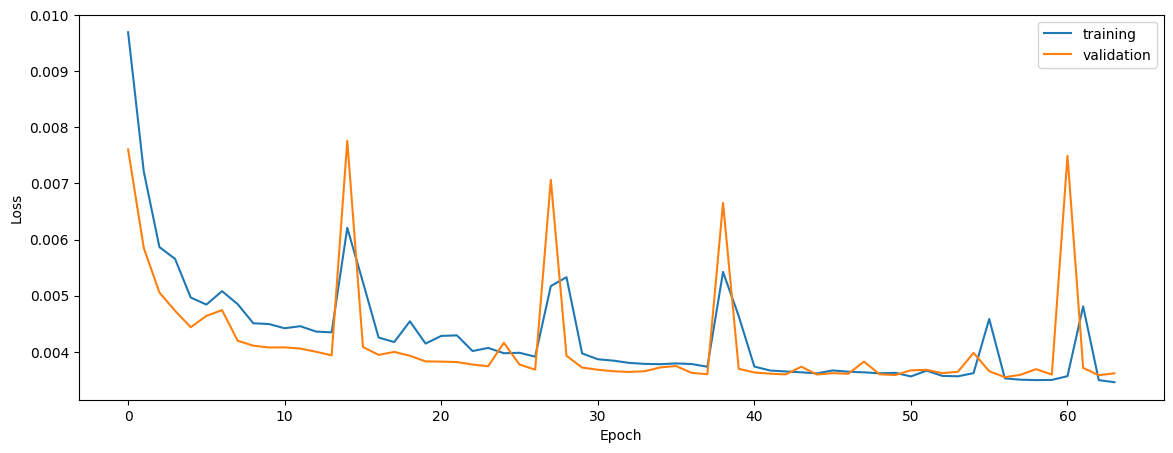

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


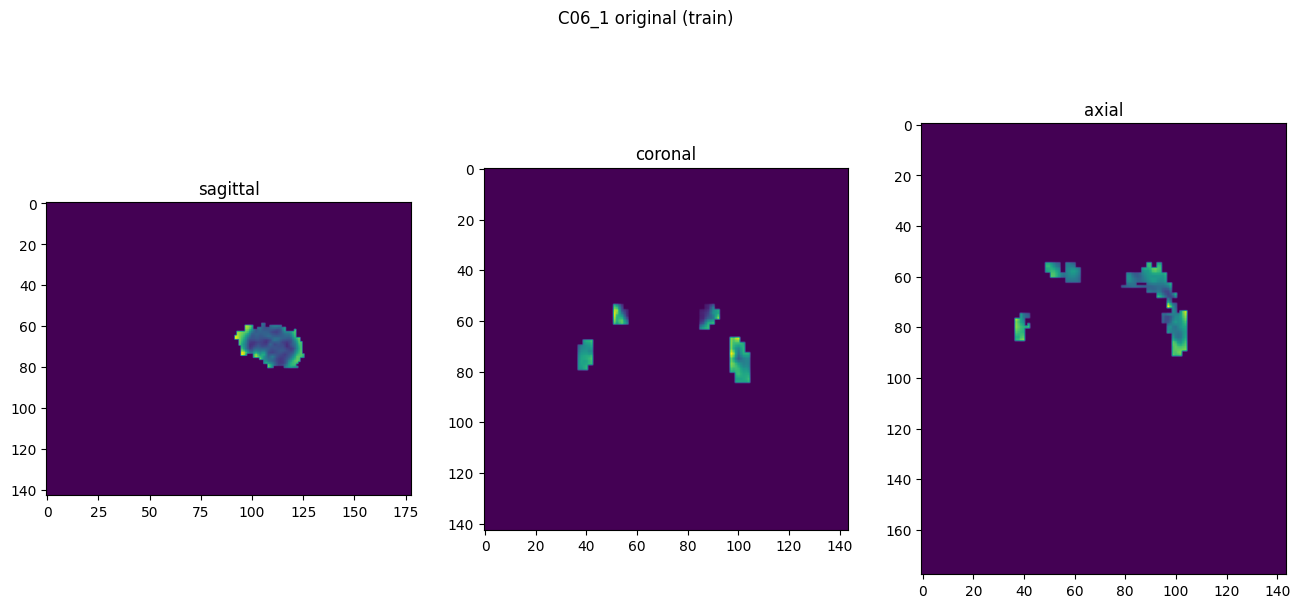

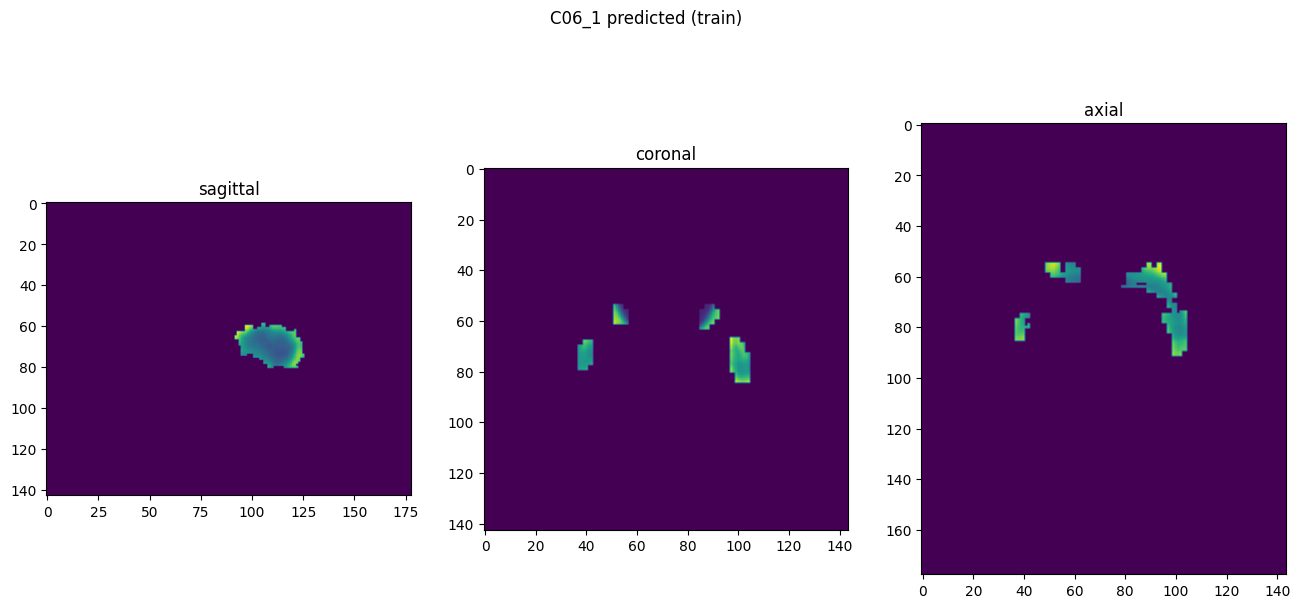

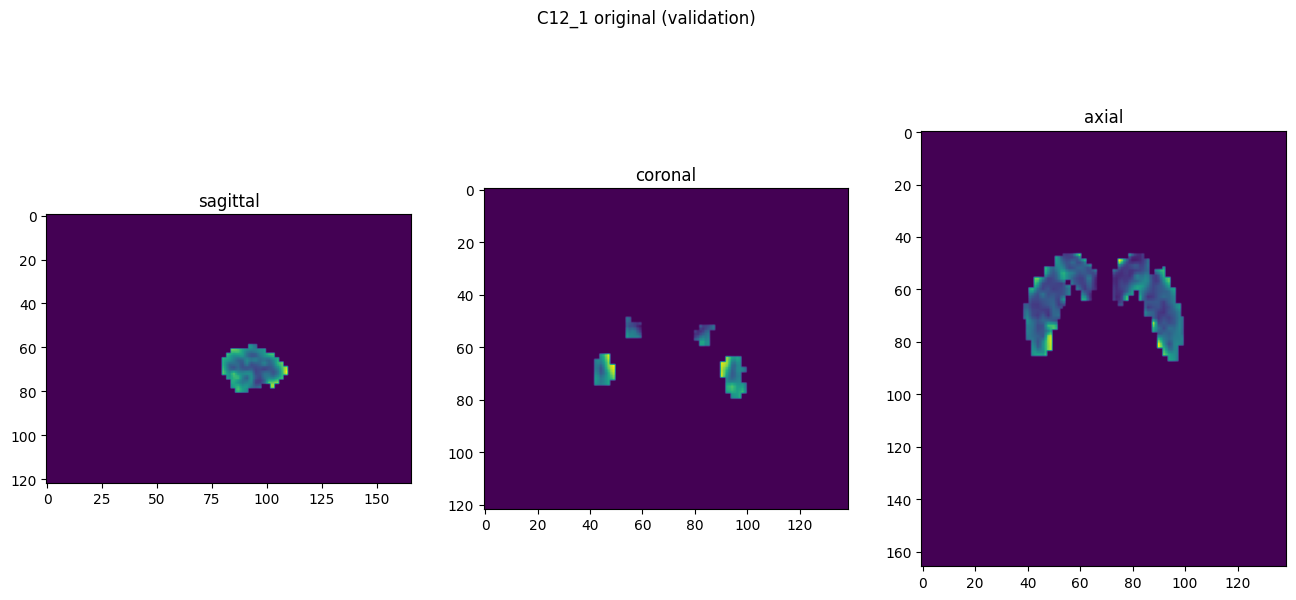

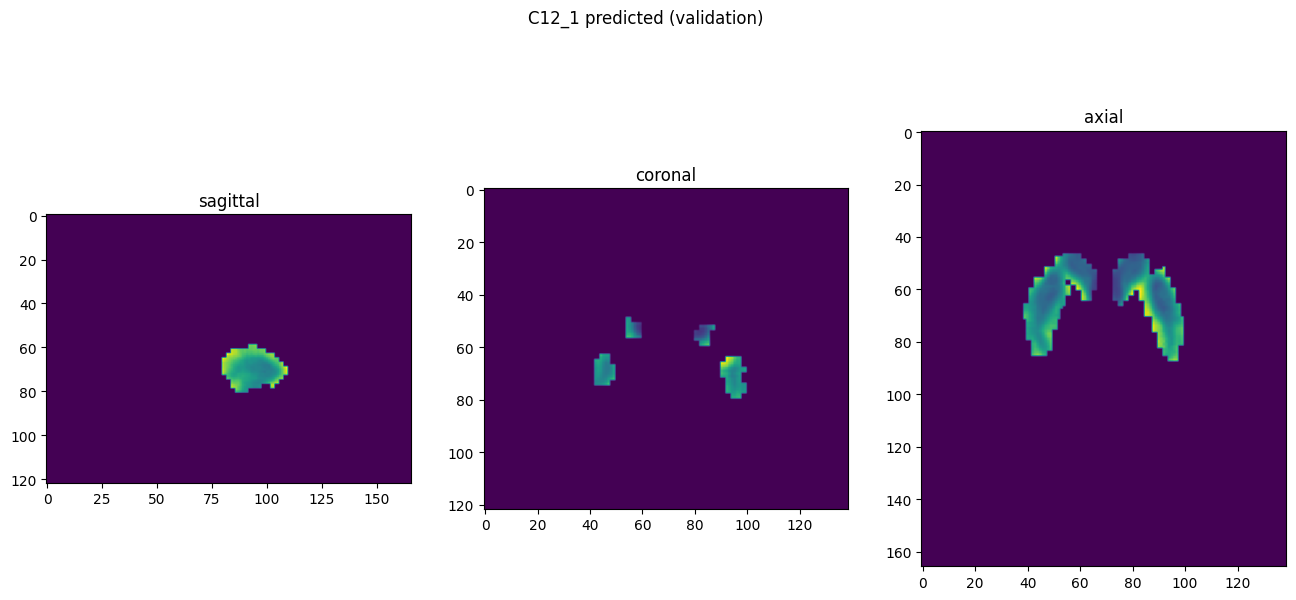

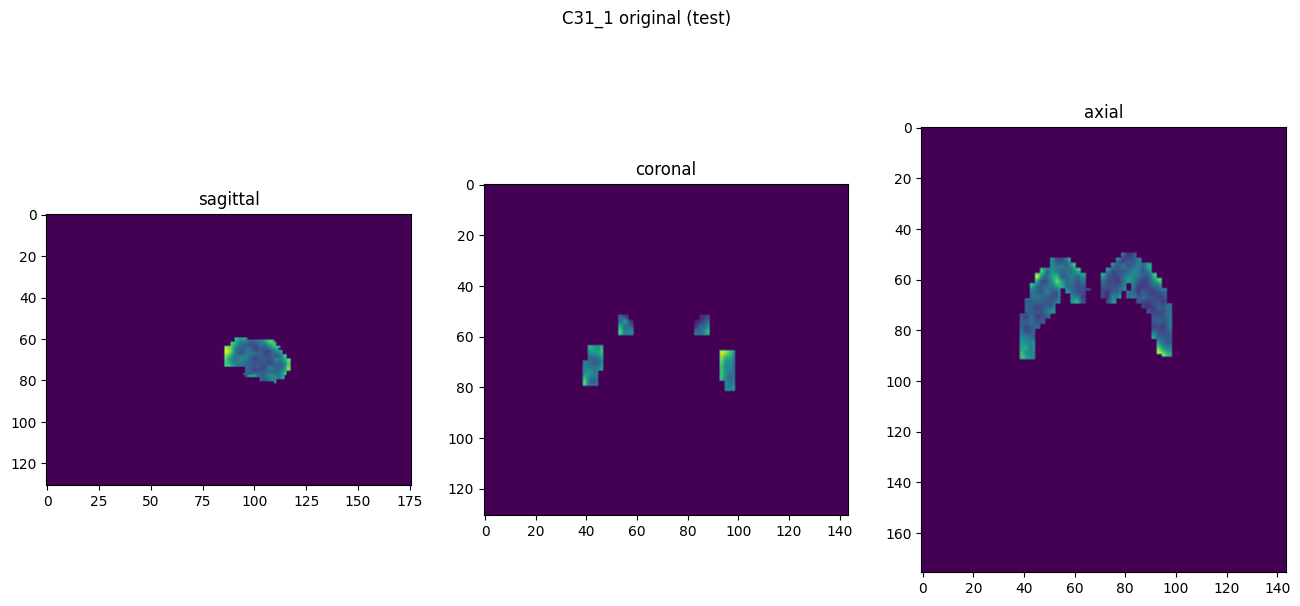

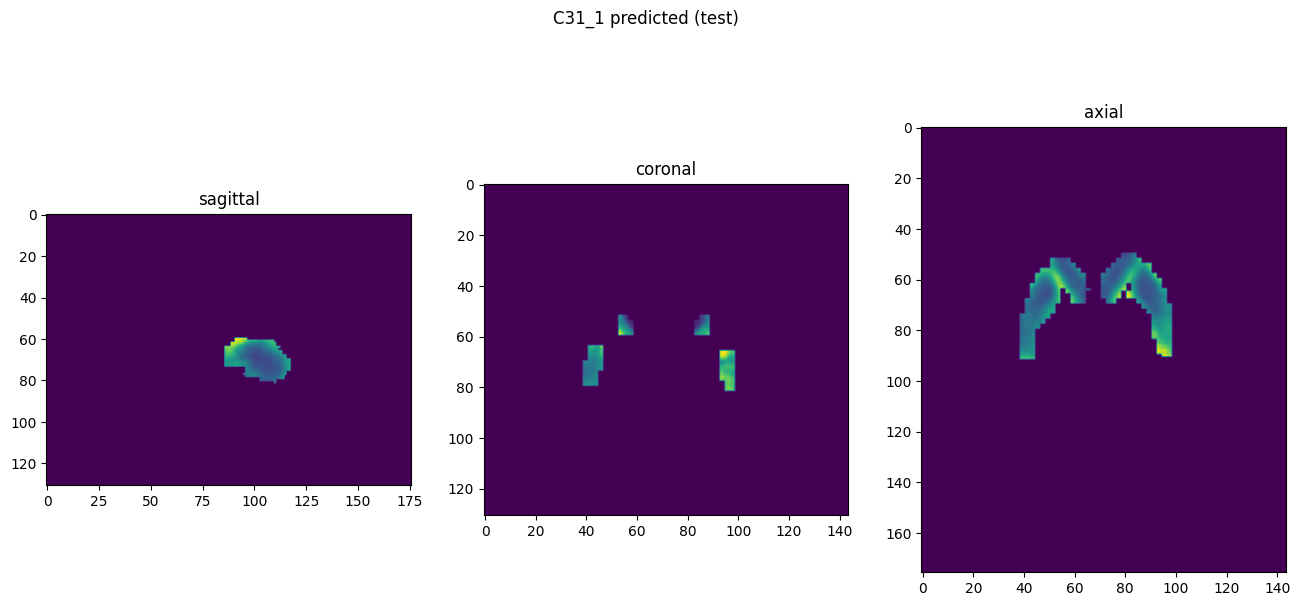

In [10]:
showResults(model, gen, threshold=None, background=False)